In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/04/2017 04:02:49 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:

import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=128
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
                
            mad=np.median(x) 
            if mad==0: mad=1
            x=x/mad
            #x=np.append(x,np.log(mad))
            x=np.append(x,mad)

            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            y=y/mad
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(128+1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [5]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [6]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [7]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [8]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [9]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [10]:
#mad=np.median(daily_data[:,-120:],1)
#mad[mad==0]=1
#mad
#daily_data=daily_data/mad.reshape(-1,1)

In [11]:
print np.mean(daily_data==0)
daily_data += (daily_data==0)*0.1
print np.mean(daily_data==0)

0.0909115851232
0.0


In [15]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [16]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [17]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [18]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=X_raw
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                error=predictions-float_labels                
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels)+1e-7)
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [19]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [20]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [21]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.optimizer, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        # config.gpu_options.per_process_gpu_memory_fraction = 0.3  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(daily_data,attrib_data,batchsize=batch_size,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [22]:
daily_data.shape

(145063, 550)

In [23]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [ ]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=128+1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_medadj', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/01/2017 02:39:00 PM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/01/2017 02:39:00 PM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)
(145063, 550) (145063, 12)


08/01/2017 02:39:13 PM INFO: shapes: [(129,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/01/2017 02:39:13 PM INFO: [epoch 0] start net training
08/01/2017 02:39:29 PM INFO: [epoch 0][step 25600] AVG LOSS: 1.08543920517, L2LOSS: 0.0
08/01/2017 02:39:45 PM INFO: [epoch 0][step 51200] AVG LOSS: 0.830950140953, L2LOSS: 0.0
08/01/2017 02:40:01 PM INFO: [epoch 0][step 76800] AVG LOSS: 0.709048390388, L2LOSS: 0.0
08/01/2017 02:40:17 PM INFO: [epoch 0][step 102400] AVG LOSS: 0.655399382114, L2LOSS: 0.0
08/01/2017 02:40:33 PM INFO: [epoch 0][step 128000] AVG LOSS: 0.648473918438, L2LOSS: 0.0
08/01/2017 02:40:49 PM INFO: [epoch 0][step 153600] AVG LOSS: 0.614213228226, L2LOSS: 0.0
08/01/2017 02:41:05 PM INFO: [epoch 0][step 179200] AVG LOSS: 0.604814052582, L2LOSS: 0.0
08/01/2017 02:41:20 PM INFO: [epoch 0][step 204800] AVG LOSS: 0.576556026936, L2LOSS: 0.0
08/01/2017 02:41:36 PM INFO: [epoch 0][step 230400] AVG LOSS: 0.569941341877, L2LOSS: 

08/01/2017 03:01:57 PM INFO: [epoch 8][step 153600] AVG LOSS: 0.473200917244, L2LOSS: 0.0
08/01/2017 03:02:13 PM INFO: [epoch 8][step 179200] AVG LOSS: 0.473472297192, L2LOSS: 0.0
08/01/2017 03:02:29 PM INFO: [epoch 8][step 204800] AVG LOSS: 0.632317364216, L2LOSS: 0.0
08/01/2017 03:02:45 PM INFO: [epoch 8][step 230400] AVG LOSS: 0.581162631512, L2LOSS: 0.0
08/01/2017 03:03:00 PM INFO: [epoch 8][step 256000] AVG LOSS: 0.531547725201, L2LOSS: 0.0
08/01/2017 03:03:01 PM INFO: [epoch 9] start net training
08/01/2017 03:03:17 PM INFO: [epoch 9][step 25600] AVG LOSS: 0.524899542332, L2LOSS: 0.0
08/01/2017 03:03:32 PM INFO: [epoch 9][step 51200] AVG LOSS: 0.517185866833, L2LOSS: 0.0
08/01/2017 03:03:48 PM INFO: [epoch 9][step 76800] AVG LOSS: 0.512461066246, L2LOSS: 0.0
08/01/2017 03:04:04 PM INFO: [epoch 9][step 102400] AVG LOSS: 0.49659499526, L2LOSS: 0.0
08/01/2017 03:04:19 PM INFO: [epoch 9][step 128000] AVG LOSS: 0.501289665699, L2LOSS: 0.0
08/01/2017 03:04:35 PM INFO: [epoch 9][step 15

08/01/2017 03:24:09 PM INFO: [epoch 17][step 25600] AVG LOSS: 0.465190589428, L2LOSS: 0.0
08/01/2017 03:24:25 PM INFO: [epoch 17][step 51200] AVG LOSS: 0.479610979557, L2LOSS: 0.0
08/01/2017 03:24:40 PM INFO: [epoch 17][step 76800] AVG LOSS: 0.457274198532, L2LOSS: 0.0
08/01/2017 03:24:56 PM INFO: [epoch 17][step 102400] AVG LOSS: 0.445856958628, L2LOSS: 0.0
08/01/2017 03:25:11 PM INFO: [epoch 17][step 128000] AVG LOSS: 0.438348054886, L2LOSS: 0.0
08/01/2017 03:25:27 PM INFO: [epoch 17][step 153600] AVG LOSS: 0.439565002918, L2LOSS: 0.0
08/01/2017 03:25:42 PM INFO: [epoch 17][step 179200] AVG LOSS: 0.440200209618, L2LOSS: 0.0
08/01/2017 03:25:58 PM INFO: [epoch 17][step 204800] AVG LOSS: 0.44495627284, L2LOSS: 0.0
08/01/2017 03:26:13 PM INFO: [epoch 17][step 230400] AVG LOSS: 0.449304014444, L2LOSS: 0.0
08/01/2017 03:26:29 PM INFO: [epoch 17][step 256000] AVG LOSS: 0.443714380264, L2LOSS: 0.0
08/01/2017 03:26:30 PM INFO: [epoch 18] start net training
08/01/2017 03:26:45 PM INFO: [epoch

08/01/2017 03:46:37 PM INFO: [epoch 25][step 179200] AVG LOSS: 0.428359210491, L2LOSS: 0.0
08/01/2017 03:46:53 PM INFO: [epoch 25][step 204800] AVG LOSS: 0.422991842031, L2LOSS: 0.0
08/01/2017 03:47:08 PM INFO: [epoch 25][step 230400] AVG LOSS: 0.428984045982, L2LOSS: 0.0
08/01/2017 03:47:24 PM INFO: [epoch 25][step 256000] AVG LOSS: 0.426885575056, L2LOSS: 0.0
08/01/2017 03:47:25 PM INFO: [epoch 26] start net training
08/01/2017 03:47:41 PM INFO: [epoch 26][step 25600] AVG LOSS: 0.426527529955, L2LOSS: 0.0
08/01/2017 03:47:56 PM INFO: [epoch 26][step 51200] AVG LOSS: 0.429237514734, L2LOSS: 0.0
08/01/2017 03:48:12 PM INFO: [epoch 26][step 76800] AVG LOSS: 0.42502194643, L2LOSS: 0.0
08/01/2017 03:48:28 PM INFO: [epoch 26][step 102400] AVG LOSS: 0.427940487862, L2LOSS: 0.0
08/01/2017 03:48:43 PM INFO: [epoch 26][step 128000] AVG LOSS: 0.429534077644, L2LOSS: 0.0
08/01/2017 03:48:59 PM INFO: [epoch 26][step 153600] AVG LOSS: 0.425054103136, L2LOSS: 0.0
08/01/2017 03:49:14 PM INFO: [epoch

08/01/2017 04:08:49 PM INFO: [epoch 34][step 51200] AVG LOSS: 0.413499474525, L2LOSS: 0.0
08/01/2017 04:09:04 PM INFO: [epoch 34][step 76800] AVG LOSS: 0.419421046972, L2LOSS: 0.0
08/01/2017 04:09:20 PM INFO: [epoch 34][step 102400] AVG LOSS: 0.411413639784, L2LOSS: 0.0
08/01/2017 04:09:36 PM INFO: [epoch 34][step 128000] AVG LOSS: 0.413686096668, L2LOSS: 0.0
08/01/2017 04:09:52 PM INFO: [epoch 34][step 153600] AVG LOSS: 0.413210779428, L2LOSS: 0.0
08/01/2017 04:10:07 PM INFO: [epoch 34][step 179200] AVG LOSS: 0.411362886429, L2LOSS: 0.0
08/01/2017 04:10:23 PM INFO: [epoch 34][step 204800] AVG LOSS: 0.418396413326, L2LOSS: 0.0
08/01/2017 04:10:38 PM INFO: [epoch 34][step 230400] AVG LOSS: 0.413052648306, L2LOSS: 0.0
08/01/2017 04:10:54 PM INFO: [epoch 34][step 256000] AVG LOSS: 0.411353111267, L2LOSS: 0.0
08/01/2017 04:10:55 PM INFO: [epoch 35] start net training
08/01/2017 04:11:11 PM INFO: [epoch 35][step 25600] AVG LOSS: 0.408111929893, L2LOSS: 0.0
08/01/2017 04:11:26 PM INFO: [epoc

08/01/2017 04:31:16 PM INFO: [epoch 42][step 204800] AVG LOSS: 0.416936278343, L2LOSS: 0.0
08/01/2017 04:31:32 PM INFO: [epoch 42][step 230400] AVG LOSS: 0.409263312817, L2LOSS: 0.0
08/01/2017 04:31:47 PM INFO: [epoch 42][step 256000] AVG LOSS: 0.404851347208, L2LOSS: 0.0
08/01/2017 04:31:49 PM INFO: [epoch 43] start net training
08/01/2017 04:32:04 PM INFO: [epoch 43][step 25600] AVG LOSS: 0.406163573265, L2LOSS: 0.0
08/01/2017 04:32:19 PM INFO: [epoch 43][step 51200] AVG LOSS: 0.408750265837, L2LOSS: 0.0
08/01/2017 04:32:35 PM INFO: [epoch 43][step 76800] AVG LOSS: 0.405761867762, L2LOSS: 0.0
08/01/2017 04:32:51 PM INFO: [epoch 43][step 102400] AVG LOSS: 0.404130548239, L2LOSS: 0.0
08/01/2017 04:33:06 PM INFO: [epoch 43][step 128000] AVG LOSS: 0.407092273235, L2LOSS: 0.0
08/01/2017 04:33:22 PM INFO: [epoch 43][step 153600] AVG LOSS: 0.424539923668, L2LOSS: 0.0
08/01/2017 04:33:38 PM INFO: [epoch 43][step 179200] AVG LOSS: 0.431687086821, L2LOSS: 0.0
08/01/2017 04:33:53 PM INFO: [epoc

08/01/2017 04:53:31 PM INFO: [epoch 51][step 76800] AVG LOSS: 0.42203348875, L2LOSS: 0.0
08/01/2017 04:53:46 PM INFO: [epoch 51][step 102400] AVG LOSS: 0.411536514759, L2LOSS: 0.0
08/01/2017 04:54:02 PM INFO: [epoch 51][step 128000] AVG LOSS: 0.40833351016, L2LOSS: 0.0
08/01/2017 04:54:17 PM INFO: [epoch 51][step 153600] AVG LOSS: 0.409606099129, L2LOSS: 0.0
08/01/2017 04:54:33 PM INFO: [epoch 51][step 179200] AVG LOSS: 0.407577782869, L2LOSS: 0.0
08/01/2017 04:54:48 PM INFO: [epoch 51][step 204800] AVG LOSS: 0.404827624559, L2LOSS: 0.0
08/01/2017 04:55:04 PM INFO: [epoch 51][step 230400] AVG LOSS: 0.407027691603, L2LOSS: 0.0
08/01/2017 04:55:19 PM INFO: [epoch 51][step 256000] AVG LOSS: 0.407058864832, L2LOSS: 0.0
08/01/2017 04:55:21 PM INFO: [epoch 52] start net training
08/01/2017 04:55:36 PM INFO: [epoch 52][step 25600] AVG LOSS: 0.403895795345, L2LOSS: 0.0
08/01/2017 04:55:52 PM INFO: [epoch 52][step 51200] AVG LOSS: 0.405439972878, L2LOSS: 0.0
08/01/2017 04:56:08 PM INFO: [epoch 

08/01/2017 05:15:56 PM INFO: [epoch 59][step 230400] AVG LOSS: 0.428401350975, L2LOSS: 0.0
08/01/2017 05:16:11 PM INFO: [epoch 59][step 256000] AVG LOSS: 0.423042148352, L2LOSS: 0.0
08/01/2017 05:16:13 PM INFO: [epoch 60] start net training
08/01/2017 05:16:28 PM INFO: [epoch 60][step 25600] AVG LOSS: 0.425125688314, L2LOSS: 0.0
08/01/2017 05:16:44 PM INFO: [epoch 60][step 51200] AVG LOSS: 0.42144843936, L2LOSS: 0.0
08/01/2017 05:16:59 PM INFO: [epoch 60][step 76800] AVG LOSS: 0.407334774733, L2LOSS: 0.0
08/01/2017 05:17:15 PM INFO: [epoch 60][step 102400] AVG LOSS: 0.402792811394, L2LOSS: 0.0
08/01/2017 05:17:30 PM INFO: [epoch 60][step 128000] AVG LOSS: 0.403579592705, L2LOSS: 0.0
08/01/2017 05:17:46 PM INFO: [epoch 60][step 153600] AVG LOSS: 0.406516611576, L2LOSS: 0.0
08/01/2017 05:18:01 PM INFO: [epoch 60][step 179200] AVG LOSS: 0.40332621336, L2LOSS: 0.0
08/01/2017 05:18:17 PM INFO: [epoch 60][step 204800] AVG LOSS: 0.401880860329, L2LOSS: 0.0
08/01/2017 05:18:32 PM INFO: [epoch 

08/01/2017 05:38:09 PM INFO: [epoch 68][step 102400] AVG LOSS: 0.398570924997, L2LOSS: 0.0
08/01/2017 05:38:25 PM INFO: [epoch 68][step 128000] AVG LOSS: 0.396403670311, L2LOSS: 0.0
08/01/2017 05:38:40 PM INFO: [epoch 68][step 153600] AVG LOSS: 0.399842083454, L2LOSS: 0.0
08/01/2017 05:38:55 PM INFO: [epoch 68][step 179200] AVG LOSS: 0.401326954365, L2LOSS: 0.0
08/01/2017 05:39:11 PM INFO: [epoch 68][step 204800] AVG LOSS: 0.402552604675, L2LOSS: 0.0
08/01/2017 05:39:26 PM INFO: [epoch 68][step 230400] AVG LOSS: 0.397850960493, L2LOSS: 0.0
08/01/2017 05:39:42 PM INFO: [epoch 68][step 256000] AVG LOSS: 0.397561371326, L2LOSS: 0.0
08/01/2017 05:39:43 PM INFO: [epoch 69] start net training
08/01/2017 05:39:59 PM INFO: [epoch 69][step 25600] AVG LOSS: 0.401974976063, L2LOSS: 0.0
08/01/2017 05:40:14 PM INFO: [epoch 69][step 51200] AVG LOSS: 0.401280134916, L2LOSS: 0.0
08/01/2017 05:40:30 PM INFO: [epoch 69][step 76800] AVG LOSS: 0.398095935583, L2LOSS: 0.0
08/01/2017 05:40:45 PM INFO: [epoc

08/01/2017 06:00:36 PM INFO: [epoch 76][step 256000] AVG LOSS: 0.39556157589, L2LOSS: 0.0
08/01/2017 06:00:37 PM INFO: [epoch 77] start net training
08/01/2017 06:00:52 PM INFO: [epoch 77][step 25600] AVG LOSS: 0.3969643116, L2LOSS: 0.0
08/01/2017 06:01:08 PM INFO: [epoch 77][step 51200] AVG LOSS: 0.392558246851, L2LOSS: 0.0
08/01/2017 06:01:24 PM INFO: [epoch 77][step 76800] AVG LOSS: 0.398174524307, L2LOSS: 0.0
08/01/2017 06:01:39 PM INFO: [epoch 77][step 102400] AVG LOSS: 0.397400736809, L2LOSS: 0.0
08/01/2017 06:01:55 PM INFO: [epoch 77][step 128000] AVG LOSS: 0.403465420008, L2LOSS: 0.0
08/01/2017 06:02:10 PM INFO: [epoch 77][step 153600] AVG LOSS: 0.399271190166, L2LOSS: 0.0
08/01/2017 06:02:26 PM INFO: [epoch 77][step 179200] AVG LOSS: 0.400254130363, L2LOSS: 0.0
08/01/2017 06:02:41 PM INFO: [epoch 77][step 204800] AVG LOSS: 0.398323863745, L2LOSS: 0.0
08/01/2017 06:02:56 PM INFO: [epoch 77][step 230400] AVG LOSS: 0.39910492301, L2LOSS: 0.0
08/01/2017 06:03:12 PM INFO: [epoch 77

08/01/2017 06:59:01 PM INFO: [epoch 99][step 102400] AVG LOSS: 0.390973180532, L2LOSS: 0.0
08/01/2017 06:59:17 PM INFO: [epoch 99][step 128000] AVG LOSS: 0.393763452768, L2LOSS: 0.0
08/01/2017 06:59:32 PM INFO: [epoch 99][step 153600] AVG LOSS: 0.396372437477, L2LOSS: 0.0
08/01/2017 06:59:48 PM INFO: [epoch 99][step 179200] AVG LOSS: 0.393650025129, L2LOSS: 0.0
08/01/2017 07:00:03 PM INFO: [epoch 99][step 204800] AVG LOSS: 0.39698818326, L2LOSS: 0.0
08/01/2017 07:00:19 PM INFO: [epoch 99][step 230400] AVG LOSS: 0.399342268705, L2LOSS: 0.0
08/01/2017 07:00:34 PM INFO: [epoch 99][step 256000] AVG LOSS: 0.398238569498, L2LOSS: 0.0
08/01/2017 07:00:35 PM INFO: [epoch 100] start net training
08/01/2017 07:00:51 PM INFO: [epoch 100][step 25600] AVG LOSS: 0.396940678358, L2LOSS: 0.0
08/01/2017 07:01:06 PM INFO: [epoch 100][step 51200] AVG LOSS: 0.394466996193, L2LOSS: 0.0
08/01/2017 07:01:22 PM INFO: [epoch 100][step 76800] AVG LOSS: 0.394647419453, L2LOSS: 0.0
08/01/2017 07:01:38 PM INFO: [e

08/01/2017 07:21:14 PM INFO: [epoch 107][step 230400] AVG LOSS: 0.394918054342, L2LOSS: 0.0
08/01/2017 07:21:30 PM INFO: [epoch 107][step 256000] AVG LOSS: 0.393042474985, L2LOSS: 0.0
08/01/2017 07:21:31 PM INFO: [epoch 108] start net training
08/01/2017 07:21:47 PM INFO: [epoch 108][step 25600] AVG LOSS: 0.394938319921, L2LOSS: 0.0
08/01/2017 07:22:03 PM INFO: [epoch 108][step 51200] AVG LOSS: 0.393453329802, L2LOSS: 0.0
08/01/2017 07:22:18 PM INFO: [epoch 108][step 76800] AVG LOSS: 0.395512610674, L2LOSS: 0.0
08/01/2017 07:22:34 PM INFO: [epoch 108][step 102400] AVG LOSS: 0.393490493298, L2LOSS: 0.0
08/01/2017 07:22:49 PM INFO: [epoch 108][step 128000] AVG LOSS: 0.392222434282, L2LOSS: 0.0
08/01/2017 07:23:05 PM INFO: [epoch 108][step 153600] AVG LOSS: 0.398786097765, L2LOSS: 0.0
08/01/2017 07:23:20 PM INFO: [epoch 108][step 179200] AVG LOSS: 0.404666483402, L2LOSS: 0.0
08/01/2017 07:23:35 PM INFO: [epoch 108][step 204800] AVG LOSS: 0.394960165024, L2LOSS: 0.0
08/01/2017 07:23:51 PM 

08/01/2017 07:43:14 PM INFO: [epoch 116][step 76800] AVG LOSS: 0.395265609026, L2LOSS: 0.0
08/01/2017 07:43:29 PM INFO: [epoch 116][step 102400] AVG LOSS: 0.394513398409, L2LOSS: 0.0
08/01/2017 07:43:45 PM INFO: [epoch 116][step 128000] AVG LOSS: 0.402978360653, L2LOSS: 0.0
08/01/2017 07:44:01 PM INFO: [epoch 116][step 153600] AVG LOSS: 0.397256493568, L2LOSS: 0.0
08/01/2017 07:44:16 PM INFO: [epoch 116][step 179200] AVG LOSS: 0.39197486639, L2LOSS: 0.0
08/01/2017 07:44:32 PM INFO: [epoch 116][step 204800] AVG LOSS: 0.40158200264, L2LOSS: 0.0
08/01/2017 07:44:48 PM INFO: [epoch 116][step 230400] AVG LOSS: 0.404066622257, L2LOSS: 0.0
08/01/2017 07:45:03 PM INFO: [epoch 116][step 256000] AVG LOSS: 0.401831060648, L2LOSS: 0.0
08/01/2017 07:45:04 PM INFO: [epoch 117] start net training
08/01/2017 07:45:20 PM INFO: [epoch 117][step 25600] AVG LOSS: 0.401179134846, L2LOSS: 0.0
08/01/2017 07:45:35 PM INFO: [epoch 117][step 51200] AVG LOSS: 0.394194573164, L2LOSS: 0.0
08/01/2017 07:45:50 PM IN

08/01/2017 08:05:27 PM INFO: [epoch 124][step 204800] AVG LOSS: 0.392660737038, L2LOSS: 0.0
08/01/2017 08:05:42 PM INFO: [epoch 124][step 230400] AVG LOSS: 0.390405118465, L2LOSS: 0.0
08/01/2017 08:05:58 PM INFO: [epoch 124][step 256000] AVG LOSS: 0.405699551105, L2LOSS: 0.0
08/01/2017 08:06:00 PM INFO: [epoch 125] start net training
08/01/2017 08:06:15 PM INFO: [epoch 125][step 25600] AVG LOSS: 0.391214817762, L2LOSS: 0.0
08/01/2017 08:06:30 PM INFO: [epoch 125][step 51200] AVG LOSS: 0.39405554533, L2LOSS: 0.0
08/01/2017 08:06:46 PM INFO: [epoch 125][step 76800] AVG LOSS: 0.391441732645, L2LOSS: 0.0
08/01/2017 08:07:01 PM INFO: [epoch 125][step 102400] AVG LOSS: 0.393241465092, L2LOSS: 0.0
08/01/2017 08:07:17 PM INFO: [epoch 125][step 128000] AVG LOSS: 0.393729478121, L2LOSS: 0.0
08/01/2017 08:07:32 PM INFO: [epoch 125][step 153600] AVG LOSS: 0.392401278019, L2LOSS: 0.0
08/01/2017 08:07:48 PM INFO: [epoch 125][step 179200] AVG LOSS: 0.405333787203, L2LOSS: 0.0
08/01/2017 08:08:04 PM I

08/01/2017 08:27:21 PM INFO: [epoch 133][step 51200] AVG LOSS: 0.390312165022, L2LOSS: 0.0
08/01/2017 08:27:37 PM INFO: [epoch 133][step 76800] AVG LOSS: 0.392212569714, L2LOSS: 0.0
08/01/2017 08:27:52 PM INFO: [epoch 133][step 102400] AVG LOSS: 0.39130294323, L2LOSS: 0.0
08/01/2017 08:28:08 PM INFO: [epoch 133][step 128000] AVG LOSS: 0.394518196583, L2LOSS: 0.0
08/01/2017 08:28:24 PM INFO: [epoch 133][step 153600] AVG LOSS: 0.391923129559, L2LOSS: 0.0
08/01/2017 08:28:39 PM INFO: [epoch 133][step 179200] AVG LOSS: 0.39043867588, L2LOSS: 0.0
08/01/2017 08:28:54 PM INFO: [epoch 133][step 204800] AVG LOSS: 0.395146101713, L2LOSS: 0.0
08/01/2017 08:29:10 PM INFO: [epoch 133][step 230400] AVG LOSS: 0.392952829599, L2LOSS: 0.0
08/01/2017 08:29:25 PM INFO: [epoch 133][step 256000] AVG LOSS: 0.391447335482, L2LOSS: 0.0
08/01/2017 08:29:27 PM INFO: [epoch 134] start net training
08/01/2017 08:29:42 PM INFO: [epoch 134][step 25600] AVG LOSS: 0.399419397116, L2LOSS: 0.0
08/01/2017 08:29:58 PM IN

08/01/2017 08:49:31 PM INFO: [epoch 141][step 179200] AVG LOSS: 0.394881248474, L2LOSS: 0.0
08/01/2017 08:49:47 PM INFO: [epoch 141][step 204800] AVG LOSS: 0.391719430685, L2LOSS: 0.0
08/01/2017 08:50:02 PM INFO: [epoch 141][step 230400] AVG LOSS: 0.388682931662, L2LOSS: 0.0
08/01/2017 08:50:18 PM INFO: [epoch 141][step 256000] AVG LOSS: 0.392009496689, L2LOSS: 0.0
08/01/2017 08:50:19 PM INFO: [epoch 142] start net training
08/01/2017 08:50:35 PM INFO: [epoch 142][step 25600] AVG LOSS: 0.392642974854, L2LOSS: 0.0
08/01/2017 08:50:50 PM INFO: [epoch 142][step 51200] AVG LOSS: 0.389161139727, L2LOSS: 0.0
08/01/2017 08:51:05 PM INFO: [epoch 142][step 76800] AVG LOSS: 0.39034935832, L2LOSS: 0.0
08/01/2017 08:51:21 PM INFO: [epoch 142][step 102400] AVG LOSS: 0.392018586397, L2LOSS: 0.0
08/01/2017 08:51:37 PM INFO: [epoch 142][step 128000] AVG LOSS: 0.390852421522, L2LOSS: 0.0
08/01/2017 08:51:53 PM INFO: [epoch 142][step 153600] AVG LOSS: 0.38817191124, L2LOSS: 0.0
08/01/2017 08:52:08 PM IN

08/01/2017 09:11:29 PM INFO: [epoch 150][step 25600] AVG LOSS: 0.407326936722, L2LOSS: 0.0
08/01/2017 09:11:45 PM INFO: [epoch 150][step 51200] AVG LOSS: 0.394562453032, L2LOSS: 0.0
08/01/2017 09:12:01 PM INFO: [epoch 150][step 76800] AVG LOSS: 0.392537355423, L2LOSS: 0.0
08/01/2017 09:12:16 PM INFO: [epoch 150][step 102400] AVG LOSS: 0.388226091862, L2LOSS: 0.0
08/01/2017 09:12:31 PM INFO: [epoch 150][step 128000] AVG LOSS: 0.391776323318, L2LOSS: 0.0
08/01/2017 09:12:47 PM INFO: [epoch 150][step 153600] AVG LOSS: 0.395774006844, L2LOSS: 0.0
08/01/2017 09:13:02 PM INFO: [epoch 150][step 179200] AVG LOSS: 0.389216035604, L2LOSS: 0.0
08/01/2017 09:13:18 PM INFO: [epoch 150][step 204800] AVG LOSS: 0.387453913689, L2LOSS: 0.0
08/01/2017 09:13:33 PM INFO: [epoch 150][step 230400] AVG LOSS: 0.390983819962, L2LOSS: 0.0
08/01/2017 09:13:49 PM INFO: [epoch 150][step 256000] AVG LOSS: 0.392015576363, L2LOSS: 0.0
08/01/2017 09:13:50 PM INFO: [epoch 151] start net training
08/01/2017 09:14:06 PM 

08/01/2017 09:33:42 PM INFO: [epoch 158][step 153600] AVG LOSS: 0.390484005213, L2LOSS: 0.0
08/01/2017 09:33:58 PM INFO: [epoch 158][step 179200] AVG LOSS: 0.386650472879, L2LOSS: 0.0
08/01/2017 09:34:13 PM INFO: [epoch 158][step 204800] AVG LOSS: 0.391637504101, L2LOSS: 0.0
08/01/2017 09:34:29 PM INFO: [epoch 158][step 230400] AVG LOSS: 0.391123652458, L2LOSS: 0.0
08/01/2017 09:34:44 PM INFO: [epoch 158][step 256000] AVG LOSS: 0.389281779528, L2LOSS: 0.0
08/01/2017 09:34:46 PM INFO: [epoch 159] start net training
08/01/2017 09:35:01 PM INFO: [epoch 159][step 25600] AVG LOSS: 0.391637951136, L2LOSS: 0.0
08/01/2017 09:35:17 PM INFO: [epoch 159][step 51200] AVG LOSS: 0.39307770133, L2LOSS: 0.0
08/01/2017 09:35:32 PM INFO: [epoch 159][step 76800] AVG LOSS: 0.387961238623, L2LOSS: 0.0
08/01/2017 09:35:48 PM INFO: [epoch 159][step 102400] AVG LOSS: 0.392572760582, L2LOSS: 0.0
08/01/2017 09:36:03 PM INFO: [epoch 159][step 128000] AVG LOSS: 0.394529610872, L2LOSS: 0.0
08/01/2017 09:36:19 PM I

08/01/2017 09:55:41 PM INFO: [epoch 167] start net training
08/01/2017 09:55:56 PM INFO: [epoch 167][step 25600] AVG LOSS: 0.388905525208, L2LOSS: 0.0
08/01/2017 09:56:12 PM INFO: [epoch 167][step 51200] AVG LOSS: 0.39084392786, L2LOSS: 0.0
08/01/2017 09:56:27 PM INFO: [epoch 167][step 76800] AVG LOSS: 0.3952036798, L2LOSS: 0.0
08/01/2017 09:56:42 PM INFO: [epoch 167][step 102400] AVG LOSS: 0.387288957834, L2LOSS: 0.0
08/01/2017 09:56:58 PM INFO: [epoch 167][step 128000] AVG LOSS: 0.390978008509, L2LOSS: 0.0
08/01/2017 09:57:13 PM INFO: [epoch 167][step 153600] AVG LOSS: 0.38886320591, L2LOSS: 0.0
08/01/2017 09:57:29 PM INFO: [epoch 167][step 179200] AVG LOSS: 0.392089277506, L2LOSS: 0.0
08/01/2017 09:57:44 PM INFO: [epoch 167][step 204800] AVG LOSS: 0.391613036394, L2LOSS: 0.0
08/01/2017 09:58:00 PM INFO: [epoch 167][step 230400] AVG LOSS: 0.386636763811, L2LOSS: 0.0
08/01/2017 09:58:15 PM INFO: [epoch 167][step 256000] AVG LOSS: 0.386624783278, L2LOSS: 0.0
08/01/2017 09:58:17 PM INFO

08/01/2017 10:17:51 PM INFO: [epoch 175][step 128000] AVG LOSS: 0.395480662584, L2LOSS: 0.0
08/01/2017 10:18:06 PM INFO: [epoch 175][step 153600] AVG LOSS: 0.395956605673, L2LOSS: 0.0
08/01/2017 10:18:22 PM INFO: [epoch 175][step 179200] AVG LOSS: 0.396804213524, L2LOSS: 0.0
08/01/2017 10:18:38 PM INFO: [epoch 175][step 204800] AVG LOSS: 0.394839286804, L2LOSS: 0.0
08/01/2017 10:18:54 PM INFO: [epoch 175][step 230400] AVG LOSS: 0.394229769707, L2LOSS: 0.0
08/01/2017 10:19:10 PM INFO: [epoch 175][step 256000] AVG LOSS: 0.389562755823, L2LOSS: 0.0
08/01/2017 10:19:11 PM INFO: [epoch 176] start net training
08/01/2017 10:19:26 PM INFO: [epoch 176][step 25600] AVG LOSS: 0.3858961761, L2LOSS: 0.0
08/01/2017 10:19:42 PM INFO: [epoch 176][step 51200] AVG LOSS: 0.39527964592, L2LOSS: 0.0
08/01/2017 10:19:57 PM INFO: [epoch 176][step 76800] AVG LOSS: 0.389682233334, L2LOSS: 0.0
08/01/2017 10:20:13 PM INFO: [epoch 176][step 102400] AVG LOSS: 0.387065768242, L2LOSS: 0.0
08/01/2017 10:20:28 PM INF

08/01/2017 10:40:01 PM INFO: [epoch 183][step 256000] AVG LOSS: 0.388491332531, L2LOSS: 0.0
08/01/2017 10:40:03 PM INFO: [epoch 184] start net training
08/01/2017 10:40:18 PM INFO: [epoch 184][step 25600] AVG LOSS: 0.389420092106, L2LOSS: 0.0
08/01/2017 10:40:34 PM INFO: [epoch 184][step 51200] AVG LOSS: 0.390445351601, L2LOSS: 0.0
08/01/2017 10:40:50 PM INFO: [epoch 184][step 76800] AVG LOSS: 0.389571994543, L2LOSS: 0.0
08/01/2017 10:41:05 PM INFO: [epoch 184][step 102400] AVG LOSS: 0.388426095247, L2LOSS: 0.0
08/01/2017 10:41:21 PM INFO: [epoch 184][step 128000] AVG LOSS: 0.391484260559, L2LOSS: 0.0
08/01/2017 10:41:37 PM INFO: [epoch 184][step 153600] AVG LOSS: 0.387137413025, L2LOSS: 0.0
08/01/2017 10:41:52 PM INFO: [epoch 184][step 179200] AVG LOSS: 0.386590391397, L2LOSS: 0.0
08/01/2017 10:42:08 PM INFO: [epoch 184][step 204800] AVG LOSS: 0.391296476126, L2LOSS: 0.0
08/01/2017 10:42:23 PM INFO: [epoch 184][step 230400] AVG LOSS: 0.389998018742, L2LOSS: 0.0
08/01/2017 10:42:39 PM 

08/01/2017 11:01:55 PM INFO: [epoch 192][step 102400] AVG LOSS: 0.385798215866, L2LOSS: 0.0
08/01/2017 11:02:11 PM INFO: [epoch 192][step 128000] AVG LOSS: 0.38780811429, L2LOSS: 0.0
08/01/2017 11:02:26 PM INFO: [epoch 192][step 153600] AVG LOSS: 0.391074419022, L2LOSS: 0.0
08/01/2017 11:02:42 PM INFO: [epoch 192][step 179200] AVG LOSS: 0.390762329102, L2LOSS: 0.0
08/01/2017 11:02:58 PM INFO: [epoch 192][step 204800] AVG LOSS: 0.387053996325, L2LOSS: 0.0
08/01/2017 11:03:13 PM INFO: [epoch 192][step 230400] AVG LOSS: 0.385443687439, L2LOSS: 0.0
08/01/2017 11:03:28 PM INFO: [epoch 192][step 256000] AVG LOSS: 0.389876246452, L2LOSS: 0.0
08/01/2017 11:03:30 PM INFO: [epoch 193] start net training
08/01/2017 11:03:45 PM INFO: [epoch 193][step 25600] AVG LOSS: 0.394895583391, L2LOSS: 0.0
08/01/2017 11:04:01 PM INFO: [epoch 193][step 51200] AVG LOSS: 0.395804405212, L2LOSS: 0.0
08/01/2017 11:04:16 PM INFO: [epoch 193][step 76800] AVG LOSS: 0.412769436836, L2LOSS: 0.0
08/01/2017 11:04:31 PM I

# prediction

In [12]:
sess=tf.Session()

In [13]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_medadj/model_0-0.meta')

In [14]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_medadj/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_medadj/model_0-0


08/04/2017 04:03:29 PM INFO: Restoring parameters from tmp_pred60_lstm_medadj/model_0-0


In [15]:
graph = tf.get_default_graph()

In [16]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [17]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(1000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-1))
    part_x=row[:j]
    if len(part_x)>=len1:
        xx=part_x[len(part_x)-len1:]
    else:
        xx=np.zeros(len1,dtype=np.float32)
        xx[len1-len(part_x):]=part_x

    mad=np.median(xx) 
    if mad==0: mad=1
    xx=xx/mad
    xx=np.append(xx,(mad))

    part_y=row[j:j+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    yy=yy/mad
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
            
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [18]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((1000, 129), (1000, 12), (1000, 60), (1000, 60))

In [19]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [20]:
np.where(np.isnan(X2)),np.where(np.isnan(X))

((array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)))

In [21]:
sess.run(loss,feed_dict=feed_dict)

0.39979389

In [22]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 60)


In [23]:
np.isnan(a).sum()

0

In [24]:
len(set(np.where(np.isnan(a))[0]))

0

In [25]:
a.max(),a.min()

(8415.9619, 0.00058188289)

In [26]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0),np.mean(this_loss==2),np.mean((Y==0) & (mask!=0))
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0 0.0496833333333 0.0496833333333
22791.0


0.39970842

In [27]:
MASK.sum()

57019.0

In [28]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape,np.mean(lst[lst<2]),np.mean(lst)    

479.216 (1000,) 0.479216 0.479216


Populating the interactive namespace from numpy and matplotlib
0.479216


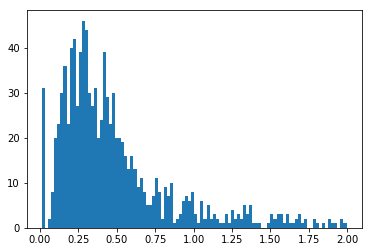

In [29]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

0.380711 1.06893 0.851132


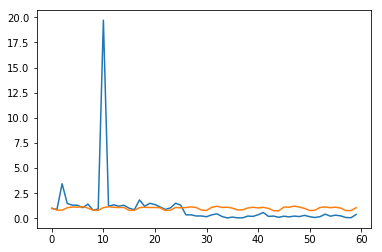

In [34]:
i=int(np.random.random()*1000)
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [35]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [38]:
X1=daily_data[:,-128:]
mad=np.median(X1,1) 
mad[mad==0]=1.0
X1=np.concatenate([X1/mad.reshape(-1,1),mad.reshape(-1,1)],axis=1)
attrib_test=attrib_data
X1.shape,attrib_test.shape

((145063, 129), (145063, 12))

In [40]:
feed_dict={x:X1,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [42]:
mad.shape

(145063,)

In [43]:
predTest=predTest*mad.reshape(-1,1)

In [49]:
predTest=np.round(predTest,1)
np.mean(predTest<0.001)

0.00077966125062903702

In [50]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [51]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [52]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.799999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.799999
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.800000
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.000000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.400000

In [53]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [54]:
keys_dict=keys["Id"].to_dict()

In [55]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [56]:
submission.isnull().sum().sum()

0L

In [57]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.799999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.799999  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.800000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.000000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.400000  75bae1fb2637

In [58]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_medadj.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")